In [10]:
import numpy as np
import cv2
import os
import keras
import tensorflow as tf
from skimage.io import imread


In [11]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [12]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# Import And Prepare The Data

In [ ]:
!unzip /gdrive/MyDrive/CelebAMask-HQ/hairdataset.zip

In [35]:
IMAGES_PATH = 'Hair-DataSet/Images'
MASKS_PATH = 'Hair-DataSet/Masks'
IMW,IMH = 256,256

In [36]:
img1 = imread(os.path.join(IMAGES_PATH,'0.jpg'))
img1_mask = imread(os.path.join(MASKS_PATH,'0.png'))

In [37]:
print(img1.shape)
print(img1_mask.shape)

(1024, 1024, 3)
(512, 512, 3)


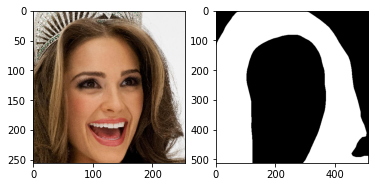

In [38]:
import matplotlib.pyplot as plt
plt.subplot(121)
plt.imshow(cv2.resize(img1,(IMW,IMH),interpolation=cv2.INTER_CUBIC))
plt.subplot(122)
plt.imshow(img1_mask)

In [39]:
tempidx = []
with open('indices.txt') as file:
  for line in file.readlines():
    idx = int(line)
    tempidx.append(idx)

In [40]:
from os.path import join

In [ ]:
sample = 6000
images,masks = np.ones((sample,IMW,IMH,1),dtype=np.float16),np.ones((sample,IMW,IMH,1),dtype=np.float16)
for i,idx in enumerate(tempidx):
  if i <sample:
    images[i] = cv2.resize(imread(join(IMAGES_PATH,f'{idx}.jpg'),as_gray=True),(IMW,IMH),interpolation=cv2.INTER_CUBIC).reshape((IMW,IMH,1))
    images[i] = images[i].astype(np.float16)
    masks[i]= cv2.resize(imread(join(MASKS_PATH,f'{idx}.png'),as_gray=True),(IMW,IMH),interpolation=cv2.INTER_CUBIC).reshape((IMW,IMH,1))
    masks[i] = masks[i].astype(np.float16)
  else:
    break
  

# Build  Model

In [42]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras

In [44]:
def get_model():
  keras.backend.clear_session()
  inputs = Input((IMW, IMH, 1))
  conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
  conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
  conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
  conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
  conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
  conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
  conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
  poo5a = MaxPooling2D(pool_size=(2, 2))(conv5)
  conv5a = Conv2D(1024, (3, 3), activation='relu', padding='same')(poo5a)
  conv5a = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5a)
  up6a = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5a), conv5], axis=3)
  conv6a = Conv2D(512, (3, 3), activation='relu', padding='same')(up6a)
  conv6a = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6a)
  up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
  conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
  conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
  up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
  conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
  conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
  up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
  conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
  conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
  up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
  conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
  conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
  conv10 = Conv2D(1, (3, 3), activation='relu', padding='same')(conv9)
  return Model(inputs=[inputs], outputs=[conv10])


In [45]:
model = get_model()
opt = tf.keras.optimizers.SGD(learning_rate=0.02,momentum=0.9)
model.compile(optimizer=opt, loss='mse', metrics=['acc'])
# model.summary()

In [47]:
epochs = 90
callbacks = [
    keras.callbacks.ModelCheckpoint("Hair-Segmintaion.h5", save_best_only=True)
]
history = model.fit(images,masks,validation_split=0.2,epochs=epochs,batch_size=64,callbacks=callbacks)


Epoch 1/90
75/75 [==============================] - 120s 1s/step - loss: 0.2053 - acc: 0.6749 - val_loss: 0.1790 - val_acc: 0.7094
Epoch 2/90
75/75 [==============================] - 99s 1s/step - loss: 0.1835 - acc: 0.7085 - val_loss: 0.1764 - val_acc: 0.7150
Epoch 3/90
75/75 [==============================] - 99s 1s/step - loss: 0.1792 - acc: 0.7160 - val_loss: 0.1706 - val_acc: 0.7269
Epoch 4/90
75/75 [==============================] - 99s 1s/step - loss: 0.1815 - acc: 0.7125 - val_loss: 0.1779 - val_acc: 0.7120
Epoch 5/90
75/75 [==============================] - 99s 1s/step - loss: 0.1789 - acc: 0.7160 - val_loss: 0.1669 - val_acc: 0.7481
Epoch 6/90
75/75 [==============================] - 99s 1s/step - loss: 0.1790 - acc: 0.7195 - val_loss: 0.1811 - val_acc: 0.7126
Epoch 7/90
75/75 [==============================] - 99s 1s/step - loss: 0.1781 - acc: 0.7179 - val_loss: 0.1654 - val_acc: 0.7425
Epoch 8/90
75/75 [==============================] - 99s 1s/step - loss: 0.1884 - acc: 0.7

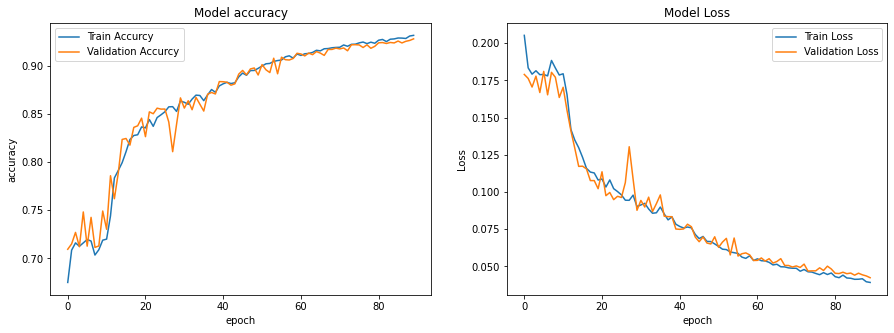

In [59]:
h = history
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(h.history['acc'],label='Train Accurcy')
plt.plot(h.history['val_acc'],label='Validation Accurcy')
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.subplot(122)
plt.plot(h.history['loss'],label='Train Loss')
plt.plot(h.history['val_loss'],label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Save Model & History

In [49]:
import json
model.save('/gdrive/MyDrive/Hair-Model2-E90LR0_02M0_9.h5')
with open('/gdrive/MyDrive/HairModelHistory.json', 'w') as file_pi:
  json.dump(history.history, file_pi)

# Evaluate

In [ ]:
import random
sample = 1750
TestImages,TestMasks = np.ones((sample,IMW,IMH,1)),np.ones((sample,IMW,IMH,1))
for i,idx in enumerate(tempidx[-sample:]):
  TestImages[i] = cv2.resize(imread(join(IMAGES_PATH,f'{idx}.jpg'),as_gray=True),(IMW,IMH),interpolation=cv2.INTER_CUBIC).reshape((IMW,IMH,1))
  TestMasks[i] = cv2.resize(imread(join(MASKS_PATH,f'{idx}.png'),as_gray=True),(IMW,IMH),interpolation=cv2.INTER_CUBIC).reshape((IMW,IMH,1))


In [88]:
score = model.evaluate(TestImages,TestMasks)
score

55/55 [==============================] - 13s 229ms/step - loss: 0.0400 - acc: 0.9303


[0.04000627249479294, 0.930327832698822]

# Predection

In [75]:
def predict(image):
    return model.predict(np.asarray([image]) ).reshape((IMW,IMH))

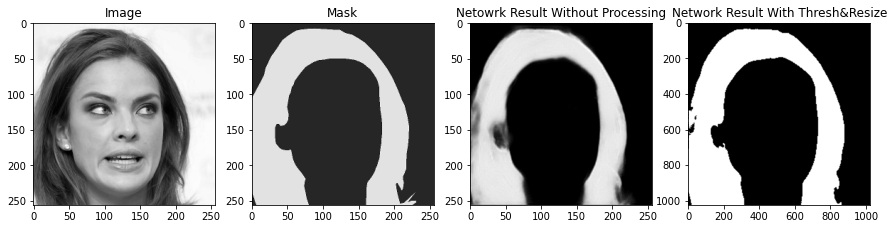

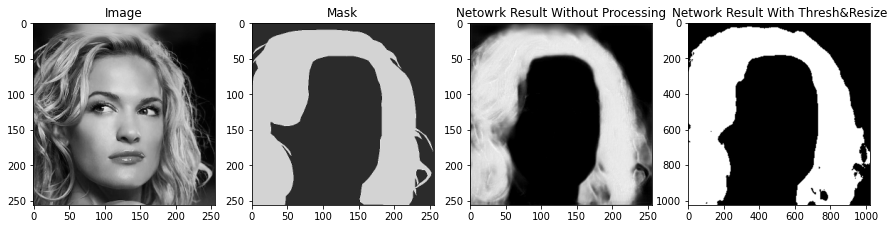

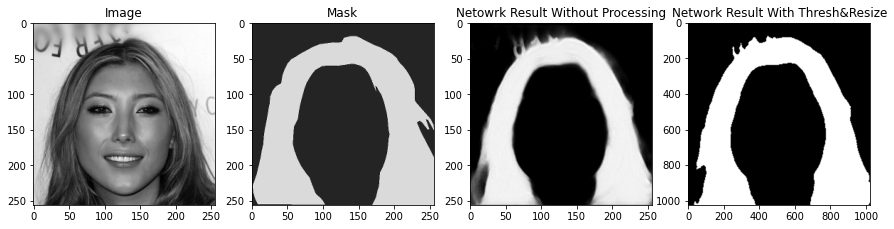

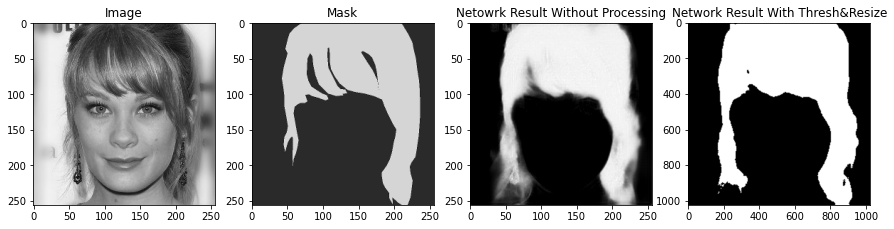

In [89]:
for idx in random.choices(range(len(TestImages)),k=4):
    res = predict(TestImages[idx])
    plt.figure(figsize=(15,5))
    plt.subplot(141)
    plt.imshow(TestImages[idx].reshape((IMW,IMH)),'gray')
    plt.title('Image')
    plt.subplot(142)
    plt.imshow(TestMasks[idx].reshape((IMW,IMH)),'gray')
    plt.title('Mask')
    plt.subplot(143)
    plt.imshow(res.copy(),'gray')
    plt.title('Netowrk Result Without Processing')
    plt.subplot(144)
    res = cv2.normalize(res, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    res = cv2.threshold(res.reshape((IMW,IMH,1)),0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    plt.imshow(cv2.resize(res,(1024,1024),interpolation=cv2.INTER_CUBIC),'gray')
    plt.title('Network Result With Thresh&Resize')